In [1]:
from __future__ import absolute_import, division, print_function

import os
import re
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import random as rnd

import seaborn as sns
import scanpy as sc
import anndata
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import sklearn
from scipy.stats import chisquare
import scanpy.external as sce
import matplotlib.cm as cm
import scipy
import warnings
from sklearn import preprocessing
import networkx as nx
import operator as op
import matplotlib.patches as mpatches
import math
from collections import Counter, defaultdict
import matplotlib.cm as mplcm
import numbers
warnings.filterwarnings('ignore')

In [14]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def calc_euclidean_dist(row, centerx, centery):
    point = np.array((row['x'], row['y']))
    cent = np.array((centerx, centery))
 
    # calculating Euclidean distance
    dist = np.linalg.norm(point - cent)
    
    return dist

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

def random_color():
    oo = np.random.choice(range(256), size=3)
    oo = [int(i) for i in oo]
    return tuple(oo)

def get_tissue_weights_bac(a, gene = None, region = None, age = None, ):
    '''
    a - anndata object
    key - str - needs to match de objects eg: 'temporal_analysis'
    plot_type - str - needs to match 'major' or 'minor'
    ** kwargs:
    key = 'annotation_analysis'
    plot_type = 'major'
    plot_values = 'modules'
    gene = ['Epcam']
    region = ['GT']
    age = ['6w']
    '''
    
    # check if key exhists
    for_keys = gene
    
    
    a_pd_mean_list = []
    for cluster_idx in for_keys:
        print(cluster_idx)

        #Get genes per cluster
        a_cluster = a.copy()
        genes_cluster = cluster_idx
        a_cluster = a_cluster[:,str(genes_cluster)]

        #print(a_cluster.obs)

        # subset to appropriate ages

        if (gene != None):
            if (region != None):
                print("Subsetting to specific genotype...")
                a_cluster = a_cluster[a_cluster.obs.Genotype.isin(region)]
                width_fig = 5
            else:
                width_fig = 3

        #print(a_cluster)
        # Scale data
        if gene != ['total_sum']:
            #a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)
            #Make sure anndata has the genes subsetted in this module aka cluster                        
            a_scaled = sklearn.preprocessing.scale(a_cluster.X.T,axis=1).mean(0)

        else:
            a_scaled = a_cluster.obs.total_counts
            #a_scaled = a.X.sum(1)
        a_anns = a_cluster.obs.annotation
        a_conds = a_cluster.obs.conditions

        #Group anndata by condition and annotations
        a_pd = pd.DataFrame([a_anns.tolist(), a_conds.tolist(), a_scaled.tolist()]).T
        a_pd.columns = ["annotation", "conditions", "value"]
        a_pd.value = a_pd.value.astype(float)
        a_pd_mean = a_pd.groupby(["annotation", "conditions"]).mean()
        #print(a_pd.groupby(["annotation", "conditions"]).sum())
        #print(a_pd_mean)

        anns_counts = a_cluster.obs.groupby(["annotation", "conditions"]).count()
        gf_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'GF_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][0]
        wt_perc = 100*anns_counts[anns_counts.index.get_level_values(1) == 'WT_6w']/a_cluster.obs.groupby(['conditions']).count()['sample'][1]
        w = pd.DataFrame(pd.concat([gf_perc,wt_perc])['sample'])
        w = w.reindex(a_pd_mean.index)
        w.columns = ['value']
        a_pd_mean['value'] = [i*j for i,j in zip(a_pd_mean['value'],w['value'])]            

        # set unique variables for plotting
        ages = np.unique([i.split("_")[1] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])
        ages = [str(j)+'w' for j in sorted([int(i.split('w')[0]) for i in ages])]
        regions = np.unique([i.split("_")[0] for i in np.unique([i for i in a_pd_mean.index.get_level_values(1)])])

        # use the same color scale across the arrays
        #vmin = min(a_scaled)
        a_pd_mean= a_pd_mean.round(2)
        vmin = 0.01*a_pd_mean.values.max()
        vmax = 0.99*a_pd_mean.values.max()
        a_pd_mean[a_pd_mean < vmin ] = 0
        a_pd_mean[a_pd_mean > vmax ] = vmax
        a_pd_mean.rename(columns = {'value':cluster_idx}, inplace=True)
        
        a_pd_mean_list.append(a_pd_mean[cluster_idx])
        
    #return_df = pd.concat(a_pd_mean_list)
    return pd.DataFrame(a_pd_mean_list)#, index = a_pd_mean.index, columns = for_keys)





In [3]:
abbreviate_anns_dict = {
    "peyer's patch": "PP",
     'epithelium': "E",
     'epithelium and mucosae':"EMM",
    'epithelium and muscle and submucosa':"ALL",
    'epithelium and mucosae and submucosa':"EMMSUB",
    'crypt apex':"APEX",
    'crypt base and mid':"LOWERMID",
    'crypt apex and crypt mid':"UPPERMID",
    'crypt base': "BASE",
    'crypt mid': "MID",
    'muscle and submucosa':"MSUB",
    'mucosae and interna':"MMI",
    'externa':"ME",
    'externa and interna':"MEI",
    'interna':"MI",
    'pellet':'PE',
    'mucosa':'MU',
    'mucosa and pellet':'MUPE',
    'epithelium and mucosa':'EMU',
    'crypt apex and mucosa':'APEXMU'
}

rename_dict = {"muscularis mucosae and muscularis propria muscularis interna and peyer's patch":"mucosae and peyer's patch",
               "epithelium and peyer's patch":"peyer's patch",
                  'epithelium and lamina propria' : 'epithelium',
    'epithelium and lamina propria and mucosa' : 'epithelium and mucosa',
    'epithelium and lamina propria and mucosa and pellet': 'epithelium and mucosa and pellet',
    'epithelium and lamina propria and muscularis mucosae' : 'epithelium and mucosae',
    'epithelium and lamina propria and muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna and submucosa all':'epithelium and muscle and submucosa',
    'epithelium and lamina propria and muscularis mucosae and submucosa all':'epithelium and mucosae and submucosa',
    "epithelium and lamina propria and peyer's patch" : "peyer's patch",
    'epithelium apex of crypt and lamina propria' : 'crypt apex',
    'crypt apex and crypt mid':'crypt apex and crypt mid',
    'epithelium base of crypt and epithelium mid crypt and lamina propria' : 'crypt base and mid',
    'epithelium base of crypt and lamina propria' : 'crypt base',
    'crypt base and lamina propria and muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna and submucosa all' : 'crypt base',
    'crypt base and muscularis mucosae and muscularis propria muscularis interna': 'crypt base',
    'crypt mid and lamina propria' : 'crypt mid',
    'mucosa and pellet' : 'mucosa and pellet',
    'muscularis all and submucosa all' : 'muscle and submucosa',
    'muscularis mucosae and muscularis propria muscularis externa and muscularis propria muscularis interna' : 'muscle and submucosa',
    'muscularis mucosae and muscularis propria muscularis interna' : 'mucosae and interna',
    "muscularis mucosae and muscularis propria muscularis interna and peyer's patch" : "peyer's patch",
    "muscularis mucosae and peyer's patch" : "peyer's patch",
    'muscularis propria muscularis externa' : 'externa',
    'muscularis propria muscularis externa and muscularis propria muscularis interna':'externa and interna',
    'muscularis propria muscularis interna':'interna',
    'muscularis propria muscularis externa and muscularis propria muscularis interna and muscularis mucosae and submucosa all' : 'muscle and submucosa',
    'pellet':'pellet',
    "peyer's patch":"peyer's patch",
    'mucosa':'mucosa',
    'crypt apex and mucosa':'crypt apex and mucosa',
    "Rest": "rest"}

# Read annotation files


In [4]:
# Read tissue section file
marked_tissue_file = '/home/sanjavickovic/data/host-microbiome_data/st_data/Bacs_Tissue_Reg_annotations.txt'

# Read file
marked_tissues = pd.read_csv(marked_tissue_file, sep='\t')
marked_tissues.rename(columns={'value':'annotation'}, inplace=True)
print(marked_tissues.head())

          image    x_y   x   y annotation
0  10015CN44_E1   16_4  16   4  Section_1
1  10015CN44_C2  17_11  17  11  Section_1
2  10015CN46_E1   19_4  19   4  Section_1
3  10015CN46_E2  13_24  13  24  Section_2
4  10015CN44_E1  10_27  10  27  Section_2


In [5]:
# Read annotation files
path = '/home/sanjavickovic/data/host-microbiome_data/st_data/splotch_ann'
annot_l = []
region_list = []
for filename in glob.glob(os.path.join(path, '*annotations.txt')):
    
    name = filename.split('/')[-1].split('_annotations.txt')[0]
    
    if name.startswith('10015'):
    
        # Read file
        annot = pd.read_csv(filename, sep='\t')
        annot.rename(columns={'value':'annotation'}, inplace=True)

        annot_melt = pd.melt(annot, id_vars=['annotation'], value_vars=['x_y'])

        annot_melt[['x', 'y']] = annot_melt["value"].str.split("_", n = 1, expand = True)

        annot_melt[['x', 'y']] = annot_melt[['x', 'y']].astype(int)
        annot_melt = annot_melt[annot_melt['value'] != 0]

        #merge with marked_tissues
        if name in marked_tissues['image'].tolist():
            marked_tissues_samp = marked_tissues[marked_tissues['image'] == name]
            annot_melt = annot_melt.merge(marked_tissues_samp, how='inner', left_on='value', right_on='x_y')    
            annot_melt = annot_melt.loc[:,['annotation_x', 'variable', 'value', 'x_x', 'y_x', 'annotation_y']]
            annot_melt.rename(columns={'annotation_x':'annotation',
                                      'annotation_y':'section',
                                      'x_x':'x',
                                      'y_x':'y',
                                      'value':'xy'}, inplace=True)
            annot_melt['name'] = name

            # Rename annotations
            #annot_melt['annotation'] = annot_melt['annotation'].map(rename_dict)

            # Get the regions
            for reg in annot_melt['annotation'].tolist():
                region_list.append(reg)

            annot_l.append(annot_melt)

print(len(list(set(region_list))))
df = pd.concat(annot_l)
print(df.head())

16
               annotation variable     xy   x   y    section          name
0  epithelium and mucosae      x_y   7_29   7  29  Section_3  10015CN73_D2
1                  pellet      x_y    8_5   8   5  Section_1  10015CN73_D2
2               crypt mid      x_y  21_11  21  11  Section_2  10015CN73_D2
3                 externa      x_y   15_9  15   9  Section_1  10015CN73_D2
4                  pellet      x_y    8_9   8   9  Section_1  10015CN73_D2


In [6]:
# interesting_regions = ['mucosa and pellet',
#  'pellet',
#  'crypt apex and crypt mid',
#  'crypt apex and mucosa'] # "peyer's patch",  'crypt base','crypt mid',

interesting_regions = ['externa', 'externa and interna', 'interna', 'muscle and submucosa',
       'mucosae and interna', 'epithelium and muscle and submucosa',
       'crypt base', 'epithelium and mucosae',
       'epithelium and mucosae and submucosa', 'crypt mid', 'epithelium',
       'crypt apex and crypt mid', 'crypt apex and mucosa',
       'mucosa and pellet', "peyer's patch", 'pellet']


# Calculate distance to centroid per section and spot
dist_l = []

for label, group in df.groupby(['name', 'section']):
    
    # Calculate centroid
    centerx, centery = centeroidnp(np.array(group.loc[:,['x', 'y']]))
    
    # For each spot calculate the euclidean distance to the centroid
    group['euclidean dist'] = group.apply(lambda row: calc_euclidean_dist(row, centerx, centery), axis=1)

    dist_l.append(group)
    
dist = pd.concat(dist_l)
#dist = dist[dist['annotation'].isin(interesting_regions)]

print(dist.head())

             annotation variable     xy   x   y    section          name  \
3                pellet      x_y  22_10  22  10  Section_1  10015CN44_C1   
7   externa and interna      x_y  24_15  24  15  Section_1  10015CN44_C1   
8   externa and interna      x_y   19_5  19   5  Section_1  10015CN44_C1   
10  externa and interna      x_y  27_10  27  10  Section_1  10015CN44_C1   
14               pellet      x_y  23_12  23  12  Section_1  10015CN44_C1   

    euclidean dist  
3         0.301496  
7         5.530904  
8         5.656050  
10        5.300085  
14        2.410581  


In [7]:
# Calculate mean euclidean distance per region
dist_region_mean = dist.groupby('annotation').mean()[['euclidean dist']].sort_values(by='euclidean dist', ascending=False).index
print(dist_region_mean)

Index(['externa', 'externa and interna', 'interna', 'muscle and submucosa',
       'mucosae and interna', 'epithelium and muscle and submucosa',
       'crypt base', 'epithelium and mucosae',
       'epithelium and mucosae and submucosa', 'crypt mid', 'epithelium',
       'crypt apex and crypt mid', 'crypt apex and mucosa',
       'mucosa and pellet', 'peyer's patch', 'pellet'],
      dtype='object', name='annotation')


Text(0.5, 0, '')

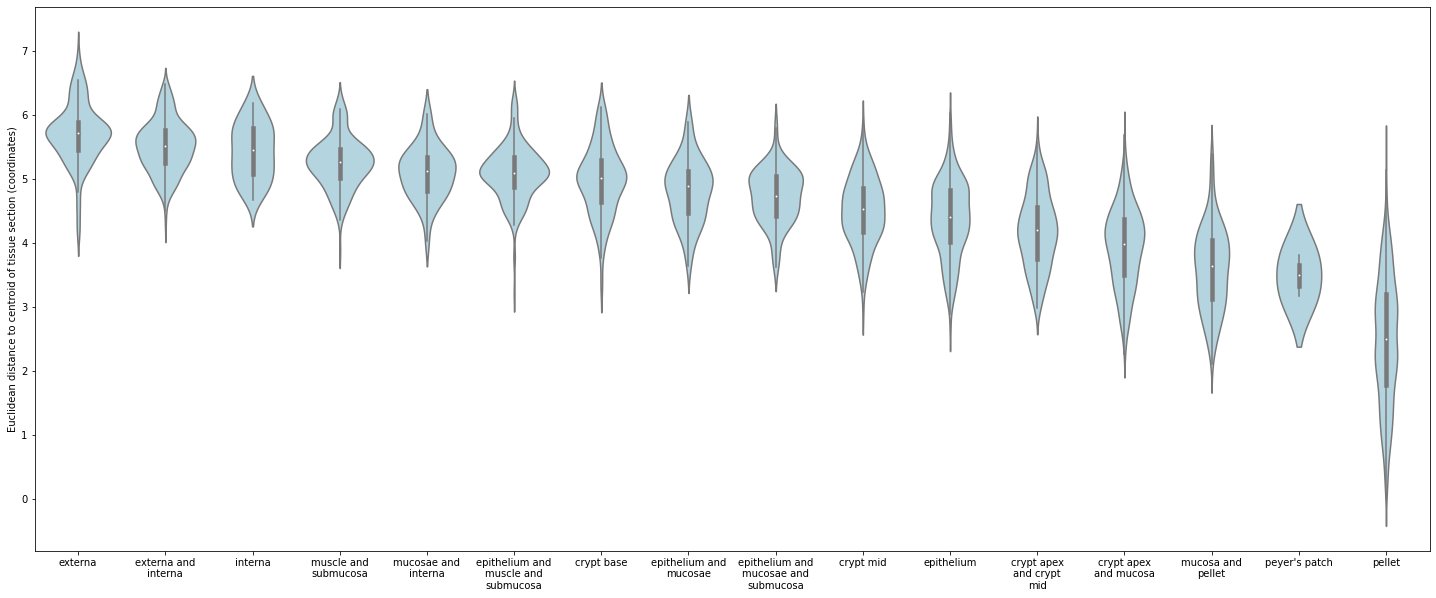

In [8]:
# Plot to validate distances
fig = plt.figure(figsize=(25, 10)) 
axes = []
for ax_idx in range(0,1):
    for i in range(1):
        ax = plt.subplot2grid((1,1), (ax_idx, i))
        
x = 'annotation'
y = 'euclidean dist'
aar_order = dist_region_mean

sns.violinplot(x=x, y=y, data=dist,ax=ax, order=aar_order, color='lightblue')

# X tick labels
new_xlabels = []
for v in ax.get_xticklabels():
    v = v.get_text()
    if len(v.split(' ')) > 4:
        new_v = ' '.join(v.split(' ')[0:2]) + '\n' + ' '.join(v.split(' ')[2:4]) + '\n' + ' '.join(v.split(' ')[4:])
    elif len(v.split(' ')) > 2:
        new_v = ' '.join(v.split(' ')[0:2]) + '\n' + ' '.join(v.split(' ')[2:])
    else:
        new_v = v
    new_xlabels.append(new_v)
ax.set_xticklabels(new_xlabels)
ax.set_ylabel('Euclidean distance to centroid of tissue section (coordinates)')
ax.set_xlabel('')

#plt.savefig("/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/manuscript/ST2.5/mRNAvsTAG_F480.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200)

In [9]:
# Mean euclidean distance per region type
dd = defaultdict(list)
dist_mean = dist.groupby('annotation').mean()[['euclidean dist']]
dist_mean = dist_mean[dist_mean.index.isin(interesting_regions)]

dist_mean_d = dist_mean.reset_index()
dist_mean_d = dict(dist_mean_d.loc[:, 'annotation'].to_dict(dd))
print(dist_mean_d )


{0: 'crypt apex and crypt mid', 1: 'crypt apex and mucosa', 2: 'crypt base', 3: 'crypt mid', 4: 'epithelium', 5: 'epithelium and mucosae', 6: 'epithelium and mucosae and submucosa', 7: 'epithelium and muscle and submucosa', 8: 'externa', 9: 'externa and interna', 10: 'interna', 11: 'mucosa and pellet', 12: 'mucosae and interna', 13: 'muscle and submucosa', 14: 'pellet', 15: "peyer's patch"}


In [229]:
# Read anndata file

tx_order = ['genus', 'family', 'order', 'class', 'phylum']

####### WEIGHTED MEAN #######

path = '/home/sanjavickovic/data/host-microbiome_data/st_data/'
fa = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))
fa.obs['Age'] = '6w'
fa.obs['conditions'] = [i+"_"+str(j) for i,j in zip(fa.obs.Genotype, fa.obs.Age)]

# Only bacteria and interesting regions
# a = fa[fa.obs['annotation'].isin(['crypt apex and crypt mid',
#                                   'crypt apex and mucosa', 'mucosa and pellet', 'pellet'])] #'crypt base', 'crypt mid', 
a = fa[:, fa.var_names.isin([i for i in fa.var_names if 'Bacteria' in i])]

# Select WT
wts = list(set([i for i in a.obs['sample'] if i.split('_')[0] in (['10015CN44', '10015CN46', '10015CN73'])]))
# a = a[a.obs['sample'].isin(wts), :]

# Change names of some bacteria
new_gene_names_in_correct_order = ['Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in a.var_names]
new_gene_names_in_correct_order = ['Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in new_gene_names_in_correct_order]
a.var_names = new_gene_names_in_correct_order

for i, tx in enumerate(tx_order):
    new = [id.split('-')[i] for id in a.var_names]
    
    pop = pd.DataFrame(a.X, columns=new)
    pop2 = pop.transpose()
    
    #if tx == 'phylum':
    #    print(pop2)
    
    # Weighten mean
    pop2_mean = pop2.groupby(by=pop2.index).mean()
    pop2_count = pop2.groupby(by=pop2.index).count()
    pop2_perc = pop2_count/pop2_count.sum()
    
    pop2_mean2 = pop2_mean * pop2_perc
    
    pop3 = pop2_mean.T
    pop3.index = a.obs.index
    
    anpop = anndata.AnnData(X=pop3, obs = a.obs)
    pop2_mean2 = get_tissue_weights_bac(anpop, gene = anpop.var_names.tolist(), )
    pop2_mean2.reset_index(inplace = True)
    pop2_mean2 = pop2_mean2.T

    pop2_mean2.reset_index(inplace = True)

    obs = pop2_mean2[['annotation', 'conditions']]

    pop2_mean2 = pop2_mean2.iloc[:,2:]

    pop2_mean2.columns = pop2_mean2.iloc[0,:]

    pop2_mean2= pop2_mean2.iloc[1:,]

    obs = obs.iloc[1:,]

    axan = sc.AnnData(X=pop2_mean2, obs=obs)
    axan = axan[axan.obs.conditions == 'WT_6w']
    
    break
    
    # ########### FILTERING
    filt_cutoff = 0
    print('Cutoff:', filt_cutoff)

    bf_bacs_num = {}
    top5bac_d = {}

    for row, col in enumerate(obs.columns):
        lsub = pop2_mean2.loc[:, [col]]

        for k,v in dist_mean_d.items():
            if v == col:
                aar = k

        # Num bacs per region
        bac_count = lsub[lsub[col] > filt_cutoff].shape[0]
        #print(col)
        #print(lsub[lsub[col] > filt_cutoff])
        #print(bac_count)
        bf_bacs_num[col] = bac_count

        # top 5 bac per region
        lsub = lsub.sort_values(by=col, ascending=False).head(3)
        top5bac_d[aar] = dict(Counter(lsub.index.tolist()))
    #sc.pp.log1p(fa_sub)
    #sc.pp.scale(fa_sub) 


# fa_scaled = sklearn.preprocessing.scale(fa_sub.X.T,axis=1).mean(0) 
# print(fa_scaled.shape)
# print(fa_scaled)
# # Extract plotted matrix and find top5 in each region
# ll = pd.DataFrame([fa_sub.obs['annotation'].tolist(), fa_scaled.tolist()]).T
# ll.columns = ["annotation","value"]
# ll.value = ll.value.astype(float)

# # Weighten mean
# ll_mean = ll.groupby(by=ll.index).mean()
# ll_count = ll.groupby(by=ll.index).count()
# ll_perc = ll_count/ll_count.sum()

# ll_mean2 = ll_mean * ll_perc
# ll3 = ll_mean2.transpose()
# print(ll3.head())





Acetobacterium
Acutalibacter
Akkermansia
Anaerobutyricum
Anaerocolumna
Anaerostipes
Bacteroides
Barnesiella
Blautia
Butyrivibrio
Clostridioides
Clostridium
Coprococcus
Duncaniella
Dysosmobacter
Enterocloster
Enterococcus
Eubacterium
Faecalibacterium
Flavonifractor
Herbinix
Hungatella
Intestinimonas
Lachnoclostridium
Lachnospira
Lacrimispora
Lactobacillus
Longicatena
Massilistercora
Mediterraneibacter
Muribaculum
Oscillibacter
Parabacteroides
Phocaeicola
Pseudobutyrivibrio
Roseburia
Ruminococcus
Ruthenibacterium
Selenomonas
Sodaliphilus
Turicibacter


In [230]:
alla = sc.AnnData(X=pop2_mean2, obs=obs)

axwt = alla[alla.obs.conditions == 'WT_6w']
axgf = alla[alla.obs.conditions == 'GF_6w']
# ########### FILTERING

filt_cutoff_gf = pd.DataFrame(axgf.X).max() 
filt_cutoff_gf.index = axgf.var_names
filt_cutoff_wt = pd.DataFrame(axwt.X).max() 
filt_cutoff_wt.index = axgf.var_names

pop2_mean2_copy = pop2_mean2.copy()
pop2_mean2_copy[pop2_mean2_copy < 2*filt_cutoff_gf+0.2*filt_cutoff_wt] = 0
alla = sc.AnnData(X=pop2_mean2_copy, obs=obs)
alla = alla[alla.obs.conditions == 'WT_6w']


In [233]:
bf_bacs_num = {}
top5bac_d = {}

allap = pd.DataFrame(alla.X)
allap.columns = alla.var_names 
for row, col in enumerate(alla.obs.annotation):
    print(col)
    lsub = allap.iloc[row,:]
    #print(lsub)
    lsub = lsub[lsub!=0]
    print(lsub)

    for k,v in dist_mean_d.items():
        if v == col:
            aar = k

    # Num bacs per region
    bac_count = len(lsub)

    
    if bac_count == 0:
        continue
        
    bf_bacs_num[col] = bac_count
    print(bac_count)
    
    # top 5 bac per region
    lsubg = lsub.sort_values(ascending=False).head(3)
    top5bac_d[col] = dict(Counter(lsubg.index.tolist()))



crypt apex and crypt mid
0
Anaerobutyricum       16.670000
Butyrivibrio           4.180000
Dysosmobacter          9.960000
Herbinix              14.370000
Hungatella            19.280001
Intestinimonas        15.610000
Mediterraneibacter    12.150000
Name: 0, dtype: float32
7
crypt apex and mucosa
0
Acetobacterium        37.570499
Acutalibacter         19.510000
Butyrivibrio           9.900000
Duncaniella           10.610000
Dysosmobacter          7.320000
Mediterraneibacter     4.710000
Oscillibacter         16.990000
Pseudobutyrivibrio    23.393700
Ruminococcus          13.810000
Sodaliphilus          24.324301
Name: 1, dtype: float32
10
crypt base
0
Anaerostipes          10.69
Butyrivibrio           6.50
Coprococcus           14.16
Herbinix              13.13
Hungatella            10.93
Intestinimonas         8.36
Mediterraneibacter    11.77
Name: 2, dtype: float32
7
crypt mid
0
Butyrivibrio           4.65
Dysosmobacter         11.30
Hungatella             7.00
Mediterraneibacter   

In [234]:
top5bac_d

{'crypt apex and crypt mid': {'Hungatella': 1,
  'Anaerobutyricum': 1,
  'Intestinimonas': 1},
 'crypt apex and mucosa': {'Acetobacterium': 1,
  'Sodaliphilus': 1,
  'Pseudobutyrivibrio': 1},
 'crypt base': {'Coprococcus': 1, 'Herbinix': 1, 'Mediterraneibacter': 1},
 'crypt mid': {'Dysosmobacter': 1, 'Hungatella': 1, 'Mediterraneibacter': 1},
 'epithelium': {'Ruminococcus': 1, 'Lachnospira': 1, 'Duncaniella': 1},
 'epithelium and muscle and submucosa': {'Acutalibacter': 1,
  'Oscillibacter': 1,
  'Butyrivibrio': 1},
 'externa': {'Intestinimonas': 1, 'Mediterraneibacter': 1, 'Butyrivibrio': 1},
 'externa and interna': {'Sodaliphilus': 1,
  'Mediterraneibacter': 1,
  'Anaerocolumna': 1},
 'mucosa and pellet': {'Oscillibacter': 1,
  'Pseudobutyrivibrio': 1,
  'Dysosmobacter': 1},
 'pellet': {'Massilistercora': 1, 'Flavonifractor': 1, 'Enterocloster': 1}}

In [213]:
# # Read anndata file

# tx_order = ['genus', 'family', 'order', 'class', 'phylum']

# path = '/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/splotch/wt_vs_gf/output6_220219'
# fa = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))

# fa_sub = fa[fa.obs['annotation'].isin(['crypt apex and crypt mid',
#                                   'crypt apex and mucosa', 'mucosa and pellet', 'pellet', 'crypt base', 'crypt mid'])] 

# # Select WT
# wts = list(set([i for i in fa_sub.obs['sample'] if i.split('_')[0] in (['10015CN44', '10015CN46', '10015CN73'])]))
# fa_sub = fa_sub[fa_sub.obs['sample'].isin(wts), :]

# # Change names of some bacteria
# bac_names = [i for i in fa.var.index if i.endswith('Bacteria')]
# bac_names = [i for i in bac_names if i not in ['Lacrimispora-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria',
#                                    'Acetobacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria']]
# bac_names = [i for i in bac_names if i in np.unique([i for i in pd.DataFrame(fa.uns['bac_annotation_analysis']['names']).values.flatten() if str(i) != 'nan'])]



# fa_sub = fa_sub[:, fa_sub.var_names.isin(bac_names)]
# new_gene_names_in_correct_order = ['Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in fa_sub.var_names]
# new_gene_names_in_correct_order = ['Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in new_gene_names_in_correct_order]
# fa_sub.var_names = new_gene_names_in_correct_order

# #sc.pp.log1p(fa_sub)
# sc.pp.scale(fa_sub) 

# # Extract plotted matrix and find top5 in each region
# ll = pd.DataFrame(fa_sub.X, columns=fa_sub.var_names, index=fa_sub.obs['annotation'])
# ll = ll.groupby(ll.index).mean().T
# #ll = ll.transform(lambda x: preprocessing.minmax_scale(x))  

# # ########### FILTERING
# filt_cutoff = 0.05*ll.values.min()
# print('Cutoff:', filt_cutoff)

# bf_bacs_num = {}
# top5bac_d = {}

# for col in ll.columns:
#     lsub = ll.loc[:, [col]]
    
#     for k,v in dist_mean_d.items():
#         if v == col:
#             aar = k
            
#     # Num bacs per region
#     bac_count = lsub[lsub[col] > filt_cutoff].shape[0]
#     #print(col)
#     #print(lsub[lsub[col] > filt_cutoff])
#     #print(bac_count)
#     bf_bacs_num[col] = bac_count
    
#     # top 5 bac per region
#     lsub = lsub.sort_values(by=col, ascending=False).head(3)
#     top5bac_d[aar] = dict(Counter(lsub.index.tolist()))



In [214]:
# # Read filtered BF file

# path = '/Users/brittalotstedt/Documents/Documents-dhcp-18-40-114-33/data/stdata/splotch/wt_vs_gf/output6_220214'

# bf = pd.read_csv(os.path.join(path, 'ST_top_gene_dict_BF0_combined.csv'), index_col=0)
# bf = bf[(bf['genotype_1'] == 'WT') & (bf['genotype_2'] == 'WT') &(bf['AAR2'] == 'Rest')] #&(bf['AAR1'] == bf['AAR2'])

# bf = bf.loc[:, ['AAR1', 'genes', 'logBFs', 'Delta']]

# new_genes = []
# new_BFs = []
# new_delta = []
# new_aar = []
# tx_order = ['genus', 'family', 'order', 'class', 'phylum']

# for ind, row in bf.iterrows():
#     for i in eval(row['genes']):
#         new_genes.append(i)
#         new_aar.append(row['AAR1'])
#     for i in eval(row['logBFs']):
#         new_BFs.append(i)
#     for i in eval(row['Delta']):
#         new_delta.append(i)
# bf = pd.DataFrame({'aar':new_aar,
#                     'genes':new_genes, 
#                   'logbf':new_BFs,
#                  'delta':new_delta})

# # Significant BFs
# #bf = bf[bf['logbf'] > 0.5] 
# #bf = bf[bf['delta'] > 5] 

# # Interesting regions
# bf = bf[bf.aar.isin(interesting_regions)]

# # Only bacs
# bf_bacs = bf[bf['genes'].str.endswith('Bacteria')]
# bf_bacs.replace({'Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria':'Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria',
#                 'Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria':'Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria'},
#                inplace=True)
# bf_bacs = bf_bacs[~bf_bacs['genes'].isin(['Lacrimispora-Lachnospiraceae-Eubacteriales-Clostridia-Firmicutes-Bacteria',
#                                    'Acetobacterium-Eubacteriaceae-Eubacteriales-Clostridia-Firmicutes-Bacteria'])]

# # Plit taxa into levels
# for i, lev in enumerate(tx_order):
#     bf_bacs[lev] = bf_bacs['genes'].str.split('-').str[i]

# ########### FILTERING
# filt_cutoff =0
    
# # Num bacs per region
# dd = defaultdict(list)
# bf_bacs_num = dict(bf_bacs[bf_bacs['delta'] > filt_cutoff].drop_duplicates(subset=['aar', 'genus']).groupby('aar').count()['genus'].to_dict(dd)) #[bf_bacs['delta'] > filt_cutoff]


In [235]:
# Pair region with bac_num
region_numbac_d = {}
for k,v in dist_mean_d.items():
    try:
        region_numbac_d[k] = bf_bacs_num[v]
    except KeyError:
        continue
        region_numbac_d[k] = 'Nan'

print(region_numbac_d)

{0: 7, 1: 10, 2: 7, 3: 4, 4: 8, 7: 4, 8: 3, 9: 6, 11: 4, 14: 35}


In [236]:
# Calculate abs distance between regions
node_df = pd.DataFrame(abs(dist_mean['euclidean dist'].values - dist_mean['euclidean dist'].values[:, None])).stack().reset_index() # columns=dist_mean.index.tolist(), index=dist_mean.index.tolist()
node_df.columns=['n1', 'n2', 'euclidean dist']
node_df = node_df[node_df['euclidean dist'] != 0]

# Scale
node_df['euclidean dist.scale'] = node_df['euclidean dist'].values.max() + 1 - node_df['euclidean dist']
node_df['euclidean dist.scale'] = node_df['euclidean dist.scale'].transform(lambda x: preprocessing.minmax_scale(x, feature_range=(1,5)))
node_df['euclidean dist.scale'] = np.exp(node_df['euclidean dist.scale']) / 10
#node_df['euclidean dist.scale'] = node_df['euclidean dist.scale'] * 0.5
node_df = node_df[(node_df.n1.isin(region_numbac_d.keys())) & (node_df.n2.isin(region_numbac_d.keys()))]
print(max(node_df['euclidean dist.scale']))
print(min(node_df['euclidean dist.scale']))


print(node_df.head())


13.095594099426242
0.2718281828459045
   n1  n2  euclidean dist  euclidean dist.scale
1   0   1        0.251958             10.975714
2   0   2        0.795953              5.584883
3   0   3        0.321093             10.072622
4   0   4        0.187846             11.885385
7   0   7        0.905724              4.873111


## Plot number of genera in each region

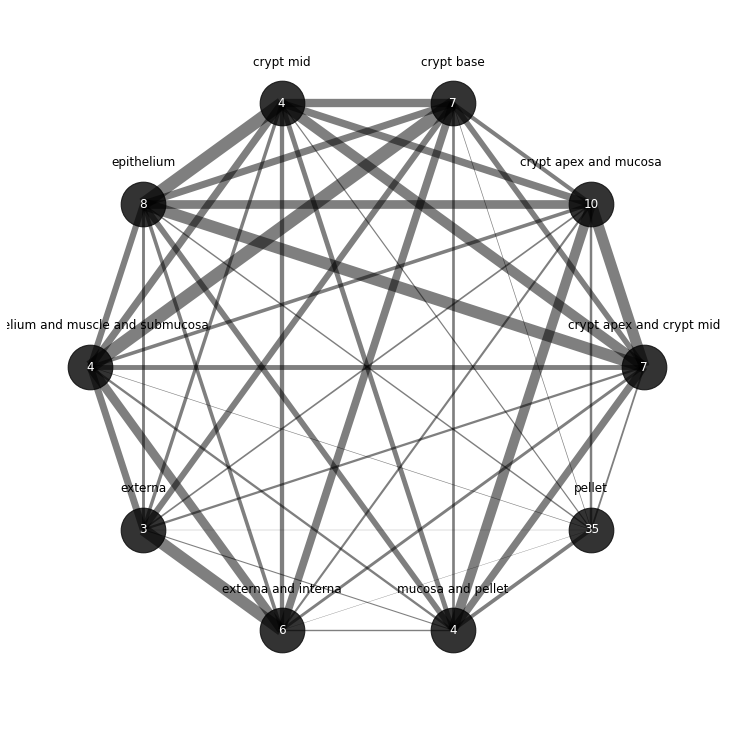

In [237]:
G = nx.from_pandas_edgelist(node_df, 'n1', 'n2', edge_attr ='euclidean dist.scale')

# Color nodes
colors = ['rosybrown', 'salmon', 'peru',  'olive', 'palegreen', 'mediumseagreen', 'teal', 'powderblue', 'slategrey', 'mediumpurple']
color_map = []
ColorLegend = {}
for node in G:
    #color_map.append(colors[node])
    node_name = dist_mean.index.tolist()[node]
    if len(node_name.split(' ')) > 10:
        node_name = ' '.join(node_name.split(' ')[0:5]) + '\n' + ' '.join(node_name.split(' ')[6:12]) + '\n' + ' '.join(node_name.split(' ')[12:])
    elif len(node_name.split(' ')) > 5:
        node_name = ' '.join(node_name.split(' ')[0:5]) + '\n' + ' '.join(node_name.split(' ')[6:])
    #ColorLegend[node_name] = colors[node]

widths = nx.get_edge_attributes(G, 'euclidean dist.scale')
nodelist = G.nodes()
dist_mean_d_sub = {key: dist_mean_d[key] for key in region_numbac_d.keys()}

# Plot
f = plt.figure(figsize=(10,10))
ax=plt.axes([0,0,1,1])
ax.set_aspect('equal')

#for label, color in ColorLegend.items():
#    ax.plot([0],[0],color=color,label=label)

pos = nx.circular_layout(G)
pos_nodes = nudge(pos, 0, 0.15)  
nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=2000,
                       node_color='black',
                       alpha=0.8)
nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=0.5)
nx.draw_networkx_labels(G, pos=pos_nodes,
                        labels=dist_mean_d_sub,
                        font_color='black')
nx.draw_networkx_labels(G, pos=pos,
                        labels=region_numbac_d,
                        font_color='white')

plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.axis('off')
f.set_facecolor('w')
plt.box(False)

#plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center right', borderaxespad=0)

plt.show()

## Plot top 5 bacs in each region

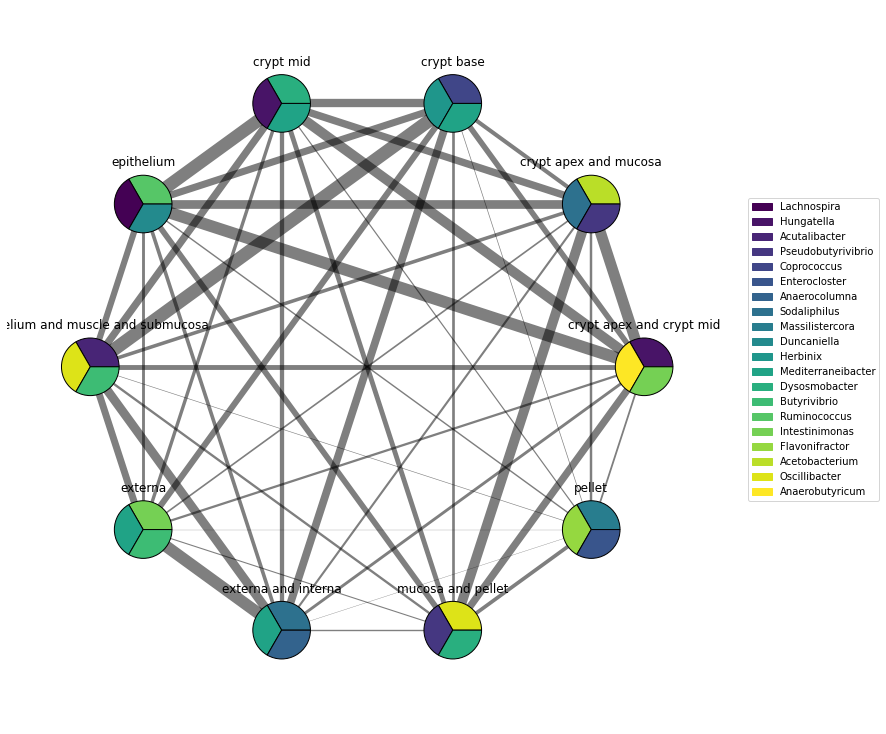

In [305]:
Com = nx.from_pandas_edgelist(node_df, 'n1', 'n2', edge_attr ='euclidean dist.scale')
nn = dict()
for key, value in dist_mean_d_sub.items():
    nn[key] = top5bac_d[value]
HistCom = nn

dist_mean_d_sub = {key: value for key, value in dist_mean_d.items() if value in top5bac_d.keys()}
pos=nx.circular_layout(Com)

fig=plt.figure(figsize=(10,10))
ax=plt.axes([0,0,1,1])
ax.set_aspect('equal')

pos_nodes = nudge(pos, 0, 0.15)  

nx.draw_networkx_edges(Com,pos,
                       edgelist = widths.keys(),
                       width=list(widths.values()),
                       edge_color='black',
                       alpha=0.5, ax=ax)
nx.draw_networkx_labels(G, pos=pos_nodes,
                        labels=dist_mean_d_sub,
                        font_color='black')

plt.xlim(-1.3,1.3)
plt.ylim(-1.3,1.3)
plt.axis('off')
f.set_facecolor('w')
plt.box(False)
trans=ax.transData.transform
trans2=fig.transFigure.inverted().transform

# Colors
num_bacs_needing_color = []
for k,v in HistCom.items():
    for ik, iv in v.items():
        num_bacs_needing_color.append(ik)
num_bacs_needing_color = list(set(num_bacs_needing_color))
    
NUM_COLORS = len(num_bacs_needing_color)

cm = plt.get_cmap('viridis')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
colormap_l = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]
colormap_d = {}
for ibac, bac in enumerate(num_bacs_needing_color):
    colormap_d[bac] = colormap_l[ibac]
inv_colormap_d = {v: k for k, v in colormap_d.items()}

piesize=0.1 #Degree
p2=piesize/2.0

dep_color = dict()
for com in Com:
    xx,yy=trans(pos[com]) # figure coordinates
    xa,ya=trans2((xx,yy)) # axes coordinates
    a = plt.axes([xa-p2,ya-p2, piesize, piesize])
    a.set_aspect('equal')
    contats = len(HistCom[com].items())
    fracs = []
    ColorFrac = []
    for dep,n in sorted(HistCom[com].items(), key=op.itemgetter(1), reverse=True):
        fracs.append(n/sum(HistCom[com].values()))
        dep_color[dep] = colormap_d[dep]
        ColorFrac.append(dep_color[dep])
    a.pie(fracs, colors = ColorFrac, wedgeprops={"edgecolor":"k"})

P = [mpatches.Patch(color=col, label=inv_colormap_d[col].split('-')[0]) for col in colormap_l]
plt.legend(handles=P,bbox_to_anchor=(4.5, 3), loc='center right', borderaxespad=0)


plt.show()

In [300]:
{key: key for key, value in top5bac_d.items() if key in dist_mean_d_sub.values()}

TypeError: unhashable type: 'dict'

In [304]:

nn

{0: {'Hungatella': 1, 'Anaerobutyricum': 1, 'Intestinimonas': 1},
 1: {'Acetobacterium': 1, 'Sodaliphilus': 1, 'Pseudobutyrivibrio': 1},
 2: {'Coprococcus': 1, 'Herbinix': 1, 'Mediterraneibacter': 1},
 3: {'Dysosmobacter': 1, 'Hungatella': 1, 'Mediterraneibacter': 1},
 4: {'Ruminococcus': 1, 'Lachnospira': 1, 'Duncaniella': 1},
 7: {'Acutalibacter': 1, 'Oscillibacter': 1, 'Butyrivibrio': 1},
 8: {'Intestinimonas': 1, 'Mediterraneibacter': 1, 'Butyrivibrio': 1},
 9: {'Sodaliphilus': 1, 'Mediterraneibacter': 1, 'Anaerocolumna': 1},
 11: {'Oscillibacter': 1, 'Pseudobutyrivibrio': 1, 'Dysosmobacter': 1},
 14: {'Massilistercora': 1, 'Flavonifractor': 1, 'Enterocloster': 1}}

In [275]:
dist_mean_d[dist_mean_d == key]

'crypt apex and crypt mid'

In [279]:
top5bac_d

{'crypt apex and crypt mid': {'Hungatella': 1,
  'Anaerobutyricum': 1,
  'Intestinimonas': 1},
 'crypt apex and mucosa': {'Acetobacterium': 1,
  'Sodaliphilus': 1,
  'Pseudobutyrivibrio': 1},
 'crypt base': {'Coprococcus': 1, 'Herbinix': 1, 'Mediterraneibacter': 1},
 'crypt mid': {'Dysosmobacter': 1, 'Hungatella': 1, 'Mediterraneibacter': 1},
 'epithelium': {'Ruminococcus': 1, 'Lachnospira': 1, 'Duncaniella': 1},
 'epithelium and muscle and submucosa': {'Acutalibacter': 1,
  'Oscillibacter': 1,
  'Butyrivibrio': 1},
 'externa': {'Intestinimonas': 1, 'Mediterraneibacter': 1, 'Butyrivibrio': 1},
 'externa and interna': {'Sodaliphilus': 1,
  'Mediterraneibacter': 1,
  'Anaerocolumna': 1},
 'mucosa and pellet': {'Oscillibacter': 1,
  'Pseudobutyrivibrio': 1,
  'Dysosmobacter': 1},
 'pellet': {'Massilistercora': 1, 'Flavonifractor': 1, 'Enterocloster': 1}}

## Plot log fold change per region and per taxa level

Acetobacterium
Acutalibacter
Akkermansia
Anaerobutyricum
Anaerocolumna
Anaerostipes
Bacteroides
Barnesiella
Blautia
Butyrivibrio
Clostridioides
Clostridium
Coprococcus
Duncaniella
Dysosmobacter
Enterocloster
Enterococcus
Eubacterium
Faecalibacterium
Flavonifractor
Herbinix
Hungatella
Intestinimonas
Lachnoclostridium
Lachnospira
Lacrimispora
Lactobacillus
Longicatena
Massilistercora
Mediterraneibacter
Muribaculum
Oscillibacter
Parabacteroides
Phocaeicola
Pseudobutyrivibrio
Roseburia
Ruminococcus
Ruthenibacterium
Selenomonas
Sodaliphilus
Turicibacter


Trying to set attribute `.obs` of view, copying.
... storing 'conditions' as categorical


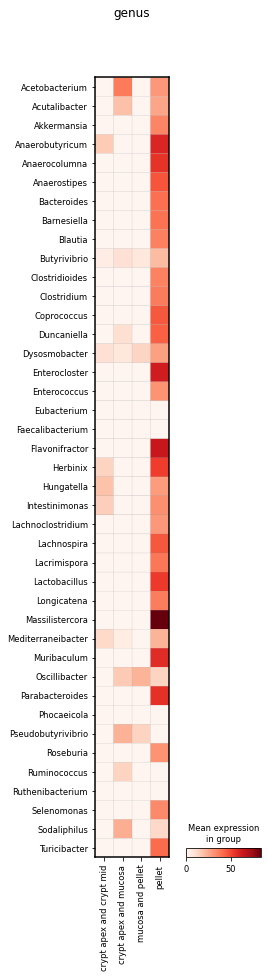

Akkermansiaceae
Bacteroidaceae
Barnesiellaceae
Clostridiaceae
Enterococcaceae
Erysipelotrichaceae
Eubacteriaceae
Eubacteriales incertae sedis
Lachnospiraceae
Lactobacillaceae
Muribaculaceae
Oscillospiraceae
Peptostreptococcaceae
Selenomonadaceae
Tannerellaceae
Turicibacteraceae


Trying to set attribute `.obs` of view, copying.
... storing 'conditions' as categorical


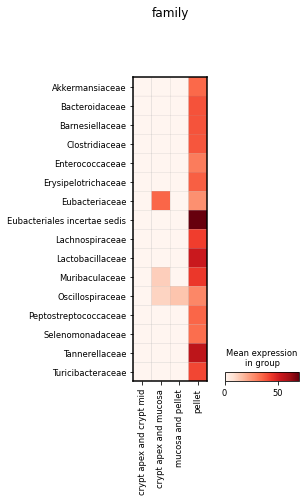

Bacteroidales
Erysipelotrichales
Eubacteriales
Lactobacillales
Selenomonadales
Verrucomicrobiales


Trying to set attribute `.obs` of view, copying.
... storing 'conditions' as categorical


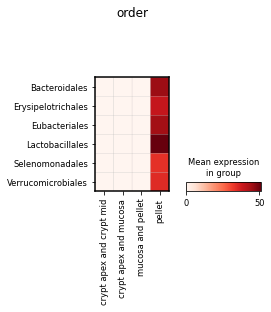

Bacilli
Bacteroidia
Clostridia
Erysipelotrichia
Negativicutes
Verrucomicrobiae


Trying to set attribute `.obs` of view, copying.
... storing 'conditions' as categorical


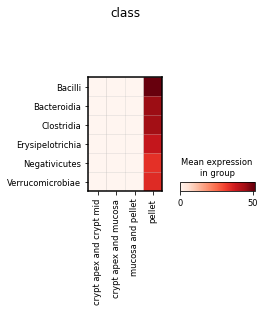

Bacteroidetes
Firmicutes
Verrucomicrobia


Trying to set attribute `.obs` of view, copying.
... storing 'conditions' as categorical


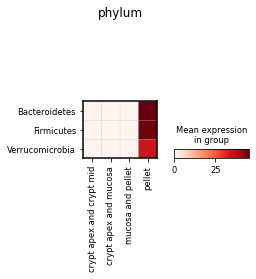

In [227]:
####### WEIGHTED MEAN #######

path = '/home/sanjavickovic/data/host-microbiome_data/st_data/'
fa = sc.read_h5ad(os.path.join(path, 'anndata_hm_norm_all_de_genes_n_Feb2022.h5ad'))
fa.obs['Age'] = '6w'
fa.obs['conditions'] = [i+"_"+str(j) for i,j in zip(fa.obs.Genotype, fa.obs.Age)]

# Only bacteria and interesting regions
# a = fa[fa.obs['annotation'].isin(['crypt apex and crypt mid',
#                                   'crypt apex and mucosa', 'mucosa and pellet', 'pellet'])] #'crypt base', 'crypt mid', 
a = fa[:, fa.var_names.isin([i for i in fa.var_names if 'Bacteria' in i])]

# Select WT
wts = list(set([i for i in a.obs['sample'] if i.split('_')[0] in (['10015CN44', '10015CN46', '10015CN73'])]))
# a = a[a.obs['sample'].isin(wts), :]

# Change names of some bacteria
new_gene_names_in_correct_order = ['Massilistercora-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Massilistercora-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in a.var_names]
new_gene_names_in_correct_order = ['Intestinimonas-Eubacteriales incertae sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' if id=='Intestinimonas-Eubacteriales-incertae-sedis-Eubacteriales-Clostridia-Firmicutes-Bacteria' else id for id in new_gene_names_in_correct_order]
a.var_names = new_gene_names_in_correct_order

for i, tx in enumerate(tx_order):
    new = [id.split('-')[i] for id in a.var_names]
    
    pop = pd.DataFrame(a.X, columns=new)
    pop2 = pop.transpose()
    
    #if tx == 'phylum':
    #    print(pop2)
    
    # Weighten mean
    pop2_mean = pop2.groupby(by=pop2.index).mean()   
    pop3 = pop2_mean.T
    pop3.index = a.obs.index
    
    anpop = anndata.AnnData(X=pop3, obs = a.obs)
    pop2_mean2 = get_tissue_weights_bac(anpop, gene = anpop.var_names.tolist(), )
    pop2_mean2.reset_index(inplace = True)
    pop2_mean2 = pop2_mean2.T

    pop2_mean2.reset_index(inplace = True)

    obs = pop2_mean2[['annotation', 'conditions']]

    pop2_mean2 = pop2_mean2.iloc[:,2:]

    pop2_mean2.columns = pop2_mean2.iloc[0,:]

    pop2_mean2= pop2_mean2.iloc[1:,]

    obs = obs.iloc[1:,]

    alla = sc.AnnData(X=pop2_mean2, obs=obs)
    axwt = alla[alla.obs.conditions == 'WT_6w']
    axgf = alla[alla.obs.conditions == 'GF_6w']
    # ########### FILTERING
   
    filt_cutoff_gf = pd.DataFrame(axgf.X).max() 
    filt_cutoff_gf.index = axgf.var_names
    filt_cutoff_wt = pd.DataFrame(axwt.X).max() 
    filt_cutoff_wt.index = axgf.var_names
    
    pop2_mean2[pop2_mean2 < 2*filt_cutoff_gf+0.2*filt_cutoff_wt] = 0
    ax = sc.AnnData(X=pop2_mean2, obs=obs)
    
    ax =  ax[ax.obs.annotation.isin([ 'crypt apex and crypt mid',
                                      'crypt apex and mucosa', 'mucosa and pellet', 'pellet'])]
    ax = ax[ax.obs.conditions == 'WT_6w']

    #sc.pp.scale(ax) 

    #sc.pp.filter_cells(ax, min_counts = 0.05*ax.X.min())
    #ax.X[ax.X < 0.05*ax.X.min()] = 0

    if i == 0:
        sc.pl.matrixplot(ax,  
                  var_names = ax.var_names,
                  groupby = 'annotation', cmap = 'Reds',
                swap_axes = True, vmin = 0, title=tx_order[i])
        
    elif i == 1:
        sc.pl.matrixplot(ax,  
                  var_names = ax.var_names,
                  groupby = 'annotation', 
                 cmap = 'Reds',
                swap_axes = True, vmin = 0, title=tx_order[i])

    else:
        sc.pl.matrixplot(ax,  
                  var_names = ax.var_names,
                  groupby = 'annotation',  cmap = 'Reds',
                 swap_axes = True, vmin = 0, title=tx_order[i])
    
